# **Kurs: 4050 - Photogrammetrie, Computer Vision & English**

**Autoren:**  
Jonas Meyer  
Stefan Blaser  
Prof. Dr. Stephan Nebiker

Datum: 03.04.2023

# **Uebung Direkte Sensororientierung**

### Einleitung und Zielsetzung

Bedingt durch die grossen Fortschritte in der kinematischen GNSS/INS-Prozessierung und der enormen Effizienzsteigerung hat sich die direkte Georeferenzierung zu einem Standardwerkzeug in der Photogrammetrie entwickelt. Damit die zu bestimmenden Objektkoordinaten aber auch am richtigen Ort zu liegen kommen, sind diverse Herausforderungen wie unterschiedliche Koordinatensysteme und Drehwinkel zu bewältigen. In dieser Übung lernst du die direkte Orientierung einer Kamera aus Positions- und Orientierungsparametern des Körperkoordinatensystems sowie Hebelarm und Fehlausrichtung der Kamera zu berechnen.

Am Schluss dieser Übung solltest du:

* verstehen wie die direkte Georeferenzierung einer Kamera (oder eines anderen Sensors) berechnet wird.
* in der Lage sein, die Güte der direkten Georeferenzierung anhand von Objektpunkten und selber implementierten Algorithmen visuell zu beurteilen.
* Unterschiede zwischen Photogrammetrie und Computer Vision aufzeigen können.


### Benötigte Module

* numpy
* matplotlib

### Daten

Folgende Ausgangsdaten stehen Ihnen im Verzeichnis ``data`` zur Verfügung:

- Linkes Stereo-Kamerabild einer Mobile Mapping-Befahrung vom 24.7.2014 in Basel (3511_6159.png, verzeichnungskorrigiert, Bildhauptpunkt 0/0)
- Innere Orientierungsparameter (AVT_front.io)
- Lever Arm und Misalignment (AVT_front.lm)
- Position und Ausrichtung des Bodyframes zum Zeitpunkt der Bildaufnahme
  - LV95/LN02: 
     - 2611564.1196 
     - 1267040.1573 
     - 270.2299
  - Omega, Phi, Kappa: 
     - -0.76016003°
     - -1.88501283°
     - 116.97864973°
- Objektpunktkoordinaten (Basel_TPS_FP_LV95_LN02_1010-1016.txt)
- Hilfsfunktionen um Eulerwinkel zu Rotationsmatrizen und rückwärts zu konvertieren [hier](src/utils.py).

### Abgabe

Jede Studentin und jeder Student muss funktionierendes Code-Repository rechtzeitig auf GitHub (via push-Funktion) abgeben.
Die Funktionstüchtigkeit des eigenen Codes ist sowohl mit Hilfe der vorhandenen unittests sowie anhand der Resultate vorgängig zu beurteilen.

### Vorgehen

Die Übung umfasst die folgenden Schritte:
1.	Berechnung der äusseren Orientierungsparameter (direkte Sensororientierung)
2.	Projektion Objektpunkte in Bild für die visuelle Kontrolle a) mittels Kollinearitätsgleichungen b) mittels projektive Geometrie

### Zur Info

* Zu ergänzende Code-Stellen sind mit ``#TODO`` gekennnzeichnet.
* Bei Unklarheiten bezüglich der Bedeutung englischer Begriffe aus dem Bereich Photogrammetrie kann [dieses Dokument](https://onlinelibrary.wiley.com/doi/10.1111/phor.12314) konsultiert werden.
* Für die Durchführung der unittests siehe Anleitung in [README.md](README.md).

#### Import notwendiger Module

In [2]:
import os
import numpy as np
import matplotlib.pyplot as plt

from src.utils import euler_to_rotation_matrix, rotation_matrix_to_euler

### Import innere Orientierung

Importiere die Parameter der inneren Orientierungen des Stereosystems ``AVT_front.io`` mithilfe der Funktion [np.loadtxt](https://numpy.org/doc/stable/reference/generated/numpy.loadtxt.html) und weise die Parameter der Kamera 6159 der Variable ``io_params`` zu.

In [3]:
io_stereo_sys = np.loadtxt('./data/AVT_front.io')

io_params = io_stereo_sys[0]

pix_size_x_mm, pix_size_y_mm = io_params[2:4]
num_pix_x, num_pix_y = io_params[4:6]
pd_mm = io_params[6]

# print(io_params)

In der Vorlesung "Computer Vision" wird die Kalibriermatrix $K$ als Analogie zur inneren Orientierung in der Photogrammetrie eingeführt. Für den weiteren Verlauf dieser Übung wird die Kalibriermatrix $K$ benötigt. Implementiere daher die Kalibriermatrix $K$ gemäss der untenstehenden Formel.

$ K =\begin{bmatrix} f & 0 & x_0\\ 0 & f & y_0 \\ 0 & 0 & 1\end{bmatrix} $

$f$ = Kammerakonstante ($c_K$ / $pd$) in Pixel  
$x_0, y_0$ = Koordinaten des Bildhauptpunkts in Pixel im Sensorkoordinatensystem

In [8]:
K = np.array([
    [pd_mm/pix_size_x_mm, 0, (num_pix_x/2)],
    [0, pd_mm/pix_size_y_mm, (num_pix_y/2)],
    [0, 0, 1],
    ])

### Schritt 1 - Berechnung der äusseren Orientierungsparameter (direkte Sensororientierung)

Die äussere Orientierung dieser Übung entstammt der direkten Georeferenzierung aus der Sensordatenfusion von GNSS und IMU.
Sie beinhaltet einerseits die Translation vom Ursprung des Weltkoordinatensystems zum Ursprung des Körperkoordinatensystems (Navigationszentrum) $t_{w,b}^{w}$ andererseits die Rotation vom Körperkoordinatensystem ins Weltkoordinatensystem $R_{b}^w$.

### Notation  
#### **Translationen**

Translationen entsprechen einem Vektor $v = \begin{bmatrix} x\\ y \\ z\end{bmatrix}$ von einem Ursprung ($U$) zu einem Ziel ($Z$) in einem definierten Koordinatensystem ($KS$). Es ist darauf zu achten, dass die Translationen nur an Koordinaten in demselben Koordinatensystem angebracht werden können. Die folgenden beiden Notationen beschreiben dieselbe Translation. 

$t_{KS,U}^{Z}  =  {^Z}t_{KS,U}$

#### **Rotationen**

Rotationen entsprchen einer $3x3$ Matrix welche die Rotation vom Ausgangs- ins Zielkoordinatensystem beschreiben. Es ist zu beachten, dass Rotationsmatrizen linksseitig zu multiplizieren sind.

$R_{Ausgangs-KS}^{Ziel-KS}  =  {^{Ziel-KS}}R_{Ausgangs-KS}$

Nachfolgend wird die äussere Orientierung des Körperkoordinatensystems (Body frame) definiert. Beachte die Notation der Variabeln!


Ergänze die Umrechnung von $\omega\phi\kappa$ in eine Rotationsmatrix!

In [9]:
# NOTE EO parameters are directly assigned and NOT READ FROM FILE !!

# Translation vector - and naming conventions
# t_w_w_b_m:
# t = Translation, (lower case = vector; upper case = matrix)
# w = in world coordinate system (Weltkoordinatensystem),
# w = from origin of world coordinate system,
# b = to body frame (Körperkoordinatensystem)
# m = metre
t_w_w_b_m = np.array([2611564.1196, 1267040.1573, 270.2299]) # äussere Orientierung

# Rotation angles opk
# r_b_w_opk_deg:
# r = Rotation (lower case = vector; upper case = matrix)
# b = from body frame (Körperkoordinatensystem)
# w = to world coordinate system (Weltkoordinatensystem)
# opk = omega, phi, kappa
# deg = in degrees
r_b_w_opk_deg = [-0.76016003, -1.88501283, 116.97864973]

# Compute rotation matrix R from rotation angles using function getR
# R_b_w:
# R = Rotation (lower case = vector; upper case = matrix)
# b = from body frame (Körperkoordinatensystem)
# w = to world coordinate system (Weltkoordinatensystem)
R_b_w = euler_to_rotation_matrix(r_b_w_opk_deg)  # äussere Orientierung
print(R_b_w)

[[-0.45341295 -0.89069338 -0.03289375]
 [ 0.89089923 -0.45400743  0.01325973]
 [-0.02674436 -0.02329288  0.99937089]]


### Boresight Alignment
Das Boresight-Alignment beschreibt die Translations- (Hebelarm) und eine Rotation (Fehlausrichtung) eines beliebigen Koordinatensystems in Bezug zum Körperkoordinatensystem, in unserem Fall werden der Hebelarm und die Fehlausrichtung vom Körperkoordinatensystem zum Koordinatensystems der linken Kamera des Stereosystems beschrieben. Die Parameter können, wie bei der inneren Orientierung, von einer Textdatei eingelesen werden.

Hebelarm: $t_{b, cl}^b$  
Fehlausrichtung: $R_b^{cl}$

In [10]:
# 1) Translation (lever arm) and rotation ('misalignment') (lm)
# from the body frame (b) (Körperkoordinatensystem)
# to the camera coordinate system of the left camera (cl)

b_a = np.loadtxt("data/AVT_front.lm", delimiter=" ", skiprows=0)

# t_b_b_cl_m:
# t = translation
# b = in body frame
# b = from body frame
# cl = to camera left
# m = metres
t_b_b_cl_m = b_a[0:3] # Hebelarm
r_b_cl_opk_deg = b_a[3:6]
R_b_cl = euler_to_rotation_matrix(r_b_cl_opk_deg) # Fehlausrichtung

### Berechnung äussere Orientierung des linken Stereobilds
Das Resultat der direkten Sensororientierung sind die Parameter der äusseren Orientierung der linken Stereokamera.
Bisher sind folgende Elemente gegeben:
- Äussere Orientierung des Körperkoordinatensystems $t_{w,b}^{w}$ und $R_{b}^w$
- Boresight Alignment $t_{b, cl}^b$ und $R_b^{cl}$

Implementieren Sie nun die notwendigen Berechnungsschritte um
- $t_{w,w}^{cl}$ und
- $R_{w}^{cl}$

zu erhalten.

Tipp: Eine algebraische Auflösung und/oder eine Skizze können dabei hilfreich sein!

In [15]:
# 2) Determination of EO of left camera of stereo system
# Computation of exterior orientation of left camera (of stereo system)
# Translation and rotation from world coordinate system (w) to
# camera coordinate system of left camera (cl))

### Your Implementation:

t_w_w_cl_m = (t_w_w_b_m + R_b_w@t_b_b_cl_m)
# Rotation matrix world to camera coordinate system
R_w_cl = R_b_cl @ R_b_w.T

### Schritt 2 - Projektion Objektpunkte in Bild


#### Import Objektpunkte
Importiere die Objektpunkte in der Datei "Basel_TPS_FP_LV95_LN02_1010-1016.txt" als Array in die Variable ``object_points``

In [18]:
object_points = np.loadtxt('./data/Basel_TPS_FP_LV95_LN02_1010-1016.txt')

### Schritt 2a - Rückprojektion der Objektpunkte ins Sensorkoordinatensystem anhand der Kollinearitätsgleichungen
Ergänze den untenstehenden Python-Code um die Transformation der Objektpunkte ins Sensorkoordinatensystem anhand der Kollinearitätsgleichungen:

$\begin{bmatrix} k_{x} \\ k_{y} \\ N  \end{bmatrix} =  R *  \begin{bmatrix} X - X_{0} \\ Y - Y_{0} \\ Z - Z_{0}  \end{bmatrix}$

$img_x = -c_k * \frac{k_x}{k_z}$

$img_y = -c_k * \frac{k_y}{k_z}$

Folgende Schritte sind dafür notwendig:
- Transformation der Objektkoordinaten ins Bildkoordinatensysten (zu implementieren)
- Transformation der Bildkoordinaten ins Sensorkoordinatensystem (bereits implementiert)

In [29]:
# conversion of object coordinates (X, Y, Z) to image coordinates (x, y)
op_coords = object_points[:, 1:]
# print(op_coords)

koll = R_w_cl @ (op_coords - t_w_w_cl_m).T
# print(koll)

img_x_mm = -pd_mm * (koll[0]/koll[2])
img_y_mm = -pd_mm * (koll[1]/koll[2])

# Conversion of image coordinates (x,y) to sensor coordinates (u,v)
u = img_x_mm / pix_size_x_mm + num_pix_x / 2
v = num_pix_y / 2 - img_y_mm / pix_size_y_mm

print(u)
print(v)

[1368.19543093 1364.3088103  1882.62411284 2723.69473304 1013.73028097
 2461.22114878 2263.68793851]
[1766.77092017 2229.03674577 2330.80384723 2189.99738406 1516.05719453
 1556.64796136 1508.98410531]


### Darstellung der Rückprojektion mit den Kollinearitätsgleichungen

In [30]:
if not os.path.exists('res'):
    os.mkdir('res')

img_path = 'data/3511_6159.png'

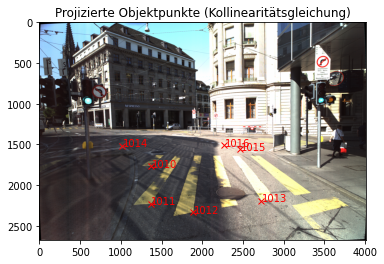

In [31]:
plt_image = plt.imread(img_path)
plt.title('Projizierte Objektpunkte (Kollinearitätsgleichung)')
plt.imshow(plt_image)
plt.plot(u, v, 'rx')
for i in range(object_points.shape[0]):
    plt.text(u[i]+10, v[i]+10, str(int(object_points[i,0])), color='red')
plt.savefig(os.path.join('res', 'object_points_koll.png'), dpi=400)

### Schritt 2a - Rückprojektion der Objektpunkte ins Sensorkoordinatensystem mittels projektiver Geometrie (Computer Vision)
Alternativ können die Objektpunkte mit der projektiven Geometrie ins Sensorkoordinatensystem zurück gerechnet werden:

$P = K * R * [I | -X0]$

$x = P * X$

Dabei gilt es zu beachten dass:
- sich die Definition des "Computer Vision"-Bildkoordinatensystems vom Bildkoordinatensystem der Photogrammetrie unterscheidet 
(falls gewünscht, mache ich gerne eine Skizze auf dem Whiteboard dazu) 
- dies entsprechende Auswirkungen auf die Rotation $R_w^{cl}$ hat:

$R_w^{{cl}_{cv}} = R_{ph}^{cv} * R_{w}^{{cl}_{ph}}$
- bei der projektiven Geometrie jeweils homogene Koordinaten verwendet werden bzw. resultieren. Sie müssen am Schluss für die Darstellung wieder in kartesische Koordinaten umgerechnet werden 
- Die Kalibriermatrix wurde bereits zu Beginn der Übung berechnet (K)

In [41]:
# Rotation matrix: rotation of camera coordinate system (as defined
# in Computer Vision) to camera coordinate system (as defined in
# photogrammetry)
# R_ph_cv = np.array[[1,0,0],[0,-1,0],[0,0,-1]]
R_ph_cv = euler_to_rotation_matrix(euler_angles=[180,0,0])
R = R_ph_cv @ R_w_cl #R_w_cl_cv

# Matrix with homogeneous object coordinates [X Y Z 1]
n_points = object_points.shape[0]
ones_col = np.ones((n_points, 1))
op_coords_h = np.hstack((object_points, ones_col))
print(op_coords_h)

# Computation of projection matrix
# P-Matrix: P = K * R * [I ¦ -X0]
P = #TODO

# Projection of object points (world coordinate system)
image_coords = #TODO

# Conversion of homogeneous to cartesian coordinates
u = #TODO
v = #TODO

[[1.01000000e+03 2.61155744e+06 1.26703378e+06 2.68284000e+02
  1.00000000e+00]
 [1.01100000e+03 2.61156008e+06 1.26703617e+06 2.68235000e+02
  1.00000000e+00]
 [1.01200000e+03 2.61156000e+06 1.26703725e+06 2.68222000e+02
  1.00000000e+00]
 [1.01300000e+03 2.61155876e+06 1.26703843e+06 2.68180000e+02
  1.00000000e+00]
 [1.01400000e+03 2.61155415e+06 1.26702818e+06 2.68447000e+02
  1.00000000e+00]
 [1.01500000e+03 2.61155129e+06 1.26703575e+06 2.68150000e+02
  1.00000000e+00]
 [1.01600000e+03 2.61155006e+06 1.26703417e+06 2.68176000e+02
  1.00000000e+00]]


ValueError: all the input arrays must have same number of dimensions, but the array at index 0 has 2 dimension(s) and the array at index 1 has 1 dimension(s)

### Darstellung der Rückprojektion mit der projektiven Geometrie

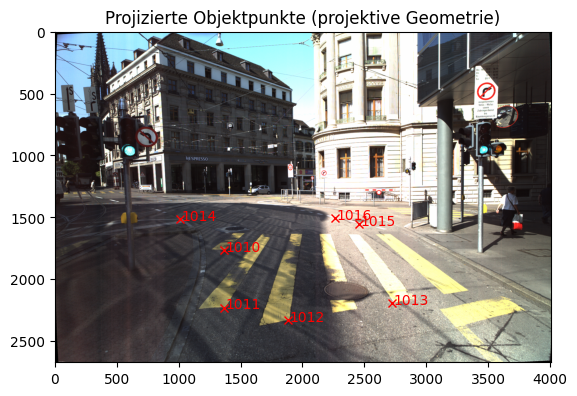

In [ ]:
plt_image = plt.imread(img_path)
plt.title('Projizierte Objektpunkte (projektive Geometrie)')
plt.imshow(plt_image)
plt.plot(u, v, 'rx')
for i in range(object_points.shape[0]):
    plt.text(u[i]+10, v[i]+10, str(int(object_points[i,0])), color='red')
plt.savefig(os.path.join('res', 'object_points_proj_geometry.png'), dpi=400)